In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset


import os
import glob
import re
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import weatherReturn
import gc  # Added for explicit garbage collection
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import pynvml
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset

# IMPROVED GPU SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # first GPU
torch.manual_seed(42)

# 1) Define a sequence dataset to create sliding windows
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len: int):
        # X: (N, feat_dim), y: (N,)
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.shape[0] - self.seq_len

    def __getitem__(self, idx):
        seq_x = self.X[idx : idx + self.seq_len]       # shape: (seq_len, feat_dim)
        target = self.y[idx + self.seq_len]            # scalar
        return seq_x, target

# 2) LSTM-based regression model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)      # out: (batch, seq_len, hidden_dim)
        last = out[:, -1, :]       # take last time step
        return self.fc(last)       # (batch, 1)

# 3) Example: Preparing data & dataloaders
SEQ_LEN = 60  # e.g., using past 7 days


# Track memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"Using device: {device}")
print_gpu_memory()

df_features = pd.read_feather('data/output/df_features_seoul.feather')

# Columns to one-hot encode
cat_cols = ['weekday', 'is_holiday', 'is_offday']

# Fit OneHotEncoder (drop first to avoid collinearity)
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Transform the categorical columns
ohe_arr = ohe.fit_transform(df_features[cat_cols])

# Retrieve the new column names
ohe_cols = ohe.get_feature_names_out(cat_cols)

# Build a DataFrame of the encoded columns
df_ohe = pd.DataFrame(ohe_arr, columns=ohe_cols, index=df_features.index)

# Concatenate back with the rest of df_features (dropping original cat_cols)
df_ml = pd.concat([
    df_features.drop(columns=cat_cols),
    df_ohe
], axis=1)

# BUILD X, y (LOG TARGET)
numeric_feats = [
    'vehicle_count',
    'T', 'RH', 'P', 'W', 'S', 'offday_run', 't',
    'weather_score','coupon_count',
    'sin_doy', 'cos_doy',
    'rain_flag', 'windy_flag', 'rain_weekend', 'hot_weekday',
    'sin_month', 'cos_month', 'days_to_hol',
    'rev_lag1', 'rev_lag7', 'rev_ma7', 'rev_std7',
    # # 인구 통계 변수
    'femlNmprCnt','maleNmprCnt', 'pct_child', 'pct_teen', 'pct_adult', 'pct_senior',
    #'totNmprCnt','femlNmprCnt','maleNmprCnt',  
    # 조정 지가
    'adj_land_price'
]
cat_feats = [c for c in df_ml.columns if
             c.startswith(('wd_','hol_','off_','q_','h_'))]
features = numeric_feats + cat_feats

X_raw = df_ml[features].values.astype(np.float32)
y_raw = np.log(df_ml['revenue_per_vehicle'].values.astype(np.float32)).reshape(-1,1)


# 3) Prepare data (replace X_raw, y_raw with your scaled numpy arrays)
# Example placeholders:
# X_raw: np.ndarray of shape (N, D)
# y_raw: np.ndarray of shape (N,)
# ---------------------------------------------------------------
scaler_X = StandardScaler(); X_scaled = scaler_X.fit_transform(X_raw)
scaler_y = StandardScaler(); y_scaled = scaler_y.fit_transform(y_raw.reshape(-1,1)).flatten()
# ---------------------------------------------------------------

dataset = SequenceDataset(torch.from_numpy(X_scaled).float(),
                          torch.from_numpy(y_scaled).float(),
                          seq_len=SEQ_LEN)



Using device: cuda
GPU Memory: 0.04 GB / 8.59 GB


In [12]:
import time
# 4) Sweep batch sizes measuring time and GPU utilization
candidate_bs = [32, 64, 128, 256, 512, 1024]
batch_times, batch_utils = {}, {}
model = LSTMRegressor(input_dim=X_scaled.shape[1]).to(device)
for bs in candidate_bs:
    loader = DataLoader(dataset, batch_size=bs, shuffle=False,
                        pin_memory=True, num_workers=0)
    # Warm-up
    try:
        seq_x, _ = next(iter(loader))
        model(seq_x.to(device))
    except Exception as e:
        print(f"Skipping batch size {bs} due to: {e}")
        continue
    # Measure over 5 batches
    utils = []
    start = time.time()
    for i, (seq_x, _) in enumerate(loader):
        if i >= 5: break
        seq_x = seq_x.to(device)
        with torch.no_grad():
            _ = model(seq_x)
        util = pynvml.nvmlDeviceGetUtilizationRates(handle).gpu
        utils.append(util)
    elapsed = time.time() - start
    batch_times[bs] = elapsed / len(utils)
    batch_utils[bs] = sum(utils) / len(utils)

print(f"Avg batch inference times: {batch_times}")
print(f"Avg GPU utilizations: {batch_utils}")
best_bs = max(batch_utils, key=batch_utils.get)
print(f"Recommended batch size (highest GPU util): {best_bs}")

Avg batch inference times: {32: 0.004960346221923828, 64: 0.008002662658691406, 128: 0.00897665023803711, 256: 0.008404254913330078, 512: 0.005159187316894531, 1024: 0.01410679817199707}
Avg GPU utilizations: {32: 27.0, 64: 27.0, 128: 27.0, 256: 77.4, 512: 90.0, 1024: 90.0}
Recommended batch size (highest GPU util): 512


In [ ]:
# 4) Hyperparameters & DataLoader settings
BATCH_SIZE = 512               # from sweep
NUM_WORKERS = 16               # parallel data loading
PIN_MEMORY = True              # accelerate host->device
PERSISTENT_WORKERS = True      # reuse workers
PREFETCH_FACTOR = 6            # batches per worker

# 5) Utility function for timed+util sweep
# [omitted: reuse earlier sweep code]

# 6) K-Fold training loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list, r2_list = [], []
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset), 1):
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)

    def make_loader(idxs, shuffle: bool):
        return DataLoader(
            Subset(dataset, idxs),
            batch_size=BATCH_SIZE,
            shuffle=shuffle,
            num_workers=NUM_WORKERS,
            pin_memory=PIN_MEMORY,
            persistent_workers=PERSISTENT_WORKERS,
            prefetch_factor=PREFETCH_FACTOR
        )

    train_loader = make_loader(train_idx, True)
    val_loader   = make_loader(val_idx, False)
    test_loader  = make_loader(test_idx, False)

    model = LSTMRegressor(input_dim=X_scaled.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scaler = GradScaler()

    best_val_loss = float('inf'); best_state = None
    for epoch in tqdm(range(1, 51), desc=f"Fold {fold}" ):
        # Train
        model.train(); train_losses = []
        for seq_x, y in train_loader:
            seq_x, y = seq_x.to(device), y.unsqueeze(1).to(device)
            optimizer.zero_grad()
            with autocast(): loss = loss_fn(model(seq_x), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            train_losses.append(loss.item())
        # Validate
        model.eval(); val_losses = []
        with torch.no_grad():
            for seq_x, y in val_loader:
                seq_x, y = seq_x.to(device), y.unsqueeze(1).to(device)
                with autocast(): val_losses.append(float(loss_fn(model(seq_x), y)))
        val_loss = np.mean(val_losses)
        if val_loss < best_val_loss:
            best_val_loss, best_state = val_loss, model.state_dict()
        tqdm.write(f"Fold {fold} Ep {epoch}: train={np.mean(train_losses):.4f}, val={val_loss:.4f}")

    # Load best and test
    model.load_state_dict(best_state)
    preds, trues = [], []
    with torch.no_grad():
        for seq_x, y in test_loader:
            seq_x = seq_x.to(device)
            with autocast(): preds.append(model(seq_x).cpu().numpy());
            trues.append(y.unsqueeze(1).numpy())
    preds = np.vstack(preds).flatten().astype(np.float32)
    trues = np.vstack(trues).flatten().astype(np.float32)

    # Inverse & metrics
    y_pred = scaler_y.inverse_transform(preds[:,None]).ravel()
    y_true = scaler_y.inverse_transform(trues[:,None]).ravel()
    y_pred, y_true = np.exp(y_pred), np.exp(y_true)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    tqdm.write(f"Fold {fold} — RMSE: {rmse:.2f}, R2: {r2:.3f}")
    rmse_list.append(rmse); r2_list.append(r2)

print(f"Avg RMSE: {np.mean(rmse_list):.2f}, Avg R2: {np.mean(r2_list):.3f}")

C:\Users\User\AppData\Local\Temp\ipykernel_1080\2110769518.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Fold 1:   0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
import torch
import torch.nn as nn
import numpy as np
import time
import pynvml
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler

# Initialize device and NVML for GPU util
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

torch.manual_seed(42)
# 1) Sequence dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len: int):
        self.X = X  # GPU tensor
        self.y = y  # GPU tensor
        self.seq_len = seq_len
    def __len__(self):
        return self.X.shape[0] - self.seq_len
    def __getitem__(self, idx):
        return self.X[idx: idx + self.seq_len], self.y[idx + self.seq_len]

# 2) Model and cuDNN tuning
torch.backends.cudnn.benchmark = True
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hidden_dim//2, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# 3) Data preparation: move entire dataset to GPU
# Replace X_scaled, y_scaled with your numpy arrays
# SEQ_LEN defined earlier (e.g., 7)
X_tensor = torch.from_numpy(X_scaled).float().to(device)
y_tensor = torch.from_numpy(y_scaled).float().to(device)
SEQ_LEN = 60
dataset = SequenceDataset(X_tensor, y_tensor, seq_len=SEQ_LEN)

# 4) Hyperparameters & DataLoader settings
BATCH_SIZE = 512               # from sweep
NUM_WORKERS = 0                # data already on GPU, no CPU workers
PIN_MEMORY = False             # not needed when data on GPU
PERSISTENT_WORKERS = False     # not needed
PREFETCH_FACTOR = 2            # minimal, workers unused

# 5) Batch-size utilization sweep (omitted for brevity)
# ... reuse previous NVML-based loop if desired

# 6) K-Fold training loop with GPU-resident data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list, r2_list = [], []
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset), 1):
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)
    def make_loader(idxs, shuffle: bool):
        return DataLoader(
            Subset(dataset, idxs),
            batch_size=BATCH_SIZE,
            shuffle=shuffle
        )

    train_loader = make_loader(train_idx, True)
    val_loader   = make_loader(val_idx, False)
    test_loader  = make_loader(test_idx, False)

    model = LSTMRegressor(input_dim=X_tensor.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    # OneCycleLR: warm up to 1e-3 then decay
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=50
    )
    loss_fn = nn.MSELoss()
    scaler = GradScaler()

    best_val_loss = float('inf'); best_state = None
    # Epoch loop
    for epoch in tqdm(range(1, 1001), desc=f"Fold {fold}"):
        # Train
        model.train()
        train_losses = []
        for seq_x, y in train_loader:
            optimizer.zero_grad()
            with autocast():
                pred = model(seq_x)
                loss = loss_fn(pred, y.unsqueeze(1))
            scaler.scale(loss).backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_losses.append(loss.item())

        # Validate
        model.eval()
        val_losses = []
        with torch.no_grad():
            for seq_x, y in val_loader:
                with autocast():
                    val_losses.append(float(loss_fn(model(seq_x), y.unsqueeze(1))))
        val_loss = np.mean(val_losses)
        if val_loss < best_val_loss:
            best_val_loss, best_state = val_loss, model.state_dict()
        cur_lr = optimizer.param_groups[0]['lr']
        tqdm.write(
            f"Fold {fold} Ep {epoch}: train={np.mean(train_losses):.4f}, val={val_loss:.4f}, lr={cur_lr:.2e}"
        )

    # Test
    model.load_state_dict(best_state)
    preds, trues = [], []
    with torch.no_grad():
        for seq_x, y in test_loader:
            with autocast("cuda"):
                preds.append(model(seq_x).cpu().numpy())
            trues.append(y.unsqueeze(1).cpu().numpy())
    preds = np.vstack(preds).flatten().astype(np.float32)
    trues = np.vstack(trues).flatten().astype(np.float32)

    # Inverse & metrics
    y_pred = scaler_y.inverse_transform(preds[:,None]).ravel()
    y_true = scaler_y.inverse_transform(trues[:,None]).ravel()
    y_pred, y_true = np.exp(y_pred), np.exp(y_true)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    tqdm.write(f"Fold {fold} — RMSE: {rmse:.2f}, R2: {r2:.3f}")
    rmse_list.append(rmse); r2_list.append(r2)

print(f"Avg RMSE: {np.mean(rmse_list):.2f}, Avg R2: {np.mean(r2_list):.3f}")


C:\Users\User\AppData\Local\Temp\ipykernel_23956\694462912.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Fold 1:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_23956\694462912.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\User\AppData\Local\Temp\ipykernel_23956\694462912.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fold 1:   0%|          | 1/1000 [00:05<1:25:55,  5.16s/it]

Fold 1 Ep 1: train=0.9810, val=0.9753, lr=5.05e-05


Fold 1:   0%|          | 2/1000 [00:10<1:23:36,  5.03s/it]

Fold 1 Ep 2: train=0.9053, val=0.8950, lr=8.15e-05


Fold 1:   0%|          | 3/1000 [00:15<1:22:53,  4.99s/it]

Fold 1 Ep 3: train=0.8745, val=0.8913, lr=1.32e-04


Fold 1:   0%|          | 4/1000 [00:20<1:23:19,  5.02s/it]

Fold 1 Ep 4: train=0.8731, val=0.8899, lr=1.99e-04


Fold 1:   0%|          | 5/1000 [00:25<1:23:33,  5.04s/it]

Fold 1 Ep 5: train=0.8717, val=0.8897, lr=2.80e-04


Fold 1:   1%|          | 6/1000 [00:30<1:23:30,  5.04s/it]

Fold 1 Ep 6: train=0.8711, val=0.8856, lr=3.72e-04


Fold 1:   1%|          | 7/1000 [00:35<1:23:04,  5.02s/it]

Fold 1 Ep 7: train=0.8690, val=0.8877, lr=4.70e-04


Fold 1:   1%|          | 8/1000 [00:40<1:24:04,  5.08s/it]

Fold 1 Ep 8: train=0.8672, val=0.8835, lr=5.71e-04


Fold 1:   1%|          | 9/1000 [00:45<1:24:26,  5.11s/it]

Fold 1 Ep 9: train=0.8665, val=0.8798, lr=6.69e-04


Fold 1:   1%|          | 10/1000 [00:50<1:24:51,  5.14s/it]

Fold 1 Ep 10: train=0.8637, val=0.8808, lr=7.60e-04


Fold 1:   1%|          | 11/1000 [00:56<1:25:11,  5.17s/it]

Fold 1 Ep 11: train=0.8625, val=0.8784, lr=8.42e-04


Fold 1:   1%|          | 12/1000 [01:01<1:25:16,  5.18s/it]

Fold 1 Ep 12: train=0.8605, val=0.8781, lr=9.09e-04


Fold 1:   1%|▏         | 13/1000 [01:06<1:25:16,  5.18s/it]

Fold 1 Ep 13: train=0.8582, val=0.8747, lr=9.59e-04


Fold 1:   1%|▏         | 14/1000 [01:11<1:25:11,  5.18s/it]

Fold 1 Ep 14: train=0.8541, val=0.8730, lr=9.90e-04


Fold 1:   2%|▏         | 15/1000 [01:16<1:25:22,  5.20s/it]

Fold 1 Ep 15: train=0.8508, val=0.8719, lr=1.00e-03


Fold 1:   2%|▏         | 16/1000 [01:22<1:25:20,  5.20s/it]

Fold 1 Ep 16: train=0.8489, val=0.8696, lr=9.98e-04


Fold 1:   2%|▏         | 17/1000 [01:27<1:25:18,  5.21s/it]

Fold 1 Ep 17: train=0.8465, val=0.8733, lr=9.92e-04


Fold 1:   2%|▏         | 18/1000 [01:32<1:25:17,  5.21s/it]

Fold 1 Ep 18: train=0.8447, val=0.8724, lr=9.82e-04


Fold 1:   2%|▏         | 19/1000 [01:37<1:25:23,  5.22s/it]

Fold 1 Ep 19: train=0.8420, val=0.8734, lr=9.68e-04


Fold 1:   2%|▏         | 20/1000 [01:42<1:25:17,  5.22s/it]

Fold 1 Ep 20: train=0.8400, val=0.8736, lr=9.50e-04


Fold 1:   2%|▏         | 21/1000 [01:48<1:25:19,  5.23s/it]

Fold 1 Ep 21: train=0.8374, val=0.8746, lr=9.29e-04


Fold 1:   2%|▏         | 22/1000 [01:53<1:25:19,  5.23s/it]

Fold 1 Ep 22: train=0.8343, val=0.8740, lr=9.04e-04


Fold 1:   2%|▏         | 23/1000 [01:58<1:25:14,  5.24s/it]

Fold 1 Ep 23: train=0.8324, val=0.8728, lr=8.76e-04


Fold 1:   2%|▏         | 24/1000 [02:03<1:25:06,  5.23s/it]

Fold 1 Ep 24: train=0.8285, val=0.8721, lr=8.45e-04


Fold 1:   2%|▎         | 25/1000 [02:09<1:25:02,  5.23s/it]

Fold 1 Ep 25: train=0.8256, val=0.8719, lr=8.12e-04


Fold 1:   3%|▎         | 26/1000 [02:14<1:24:59,  5.24s/it]

Fold 1 Ep 26: train=0.8232, val=0.8713, lr=7.75e-04


Fold 1:   3%|▎         | 27/1000 [02:19<1:24:52,  5.23s/it]

Fold 1 Ep 27: train=0.8190, val=0.8756, lr=7.37e-04


Fold 1:   3%|▎         | 28/1000 [02:24<1:24:37,  5.22s/it]

Fold 1 Ep 28: train=0.8189, val=0.8779, lr=6.96e-04


Fold 1:   3%|▎         | 29/1000 [02:30<1:24:37,  5.23s/it]

Fold 1 Ep 29: train=0.8130, val=0.8744, lr=6.54e-04


Fold 1:   3%|▎         | 30/1000 [02:35<1:24:37,  5.23s/it]

Fold 1 Ep 30: train=0.8096, val=0.8768, lr=6.11e-04


Fold 1:   3%|▎         | 31/1000 [02:40<1:24:37,  5.24s/it]

Fold 1 Ep 31: train=0.8086, val=0.8784, lr=5.67e-04


Fold 1:   3%|▎         | 32/1000 [02:45<1:24:38,  5.25s/it]

Fold 1 Ep 32: train=0.8044, val=0.8771, lr=5.22e-04


Fold 1:   3%|▎         | 33/1000 [02:51<1:24:34,  5.25s/it]

Fold 1 Ep 33: train=0.8019, val=0.8820, lr=4.77e-04


Fold 1:   3%|▎         | 34/1000 [02:56<1:24:30,  5.25s/it]

Fold 1 Ep 34: train=0.7993, val=0.8803, lr=4.33e-04


Fold 1:   4%|▎         | 35/1000 [03:01<1:24:25,  5.25s/it]

Fold 1 Ep 35: train=0.7955, val=0.8856, lr=3.88e-04


Fold 1:   4%|▎         | 36/1000 [03:06<1:24:15,  5.24s/it]

Fold 1 Ep 36: train=0.7921, val=0.8863, lr=3.45e-04


Fold 1:   4%|▎         | 37/1000 [03:12<1:24:11,  5.25s/it]

Fold 1 Ep 37: train=0.7888, val=0.8850, lr=3.03e-04


Fold 1:   4%|▍         | 38/1000 [03:17<1:24:08,  5.25s/it]

Fold 1 Ep 38: train=0.7855, val=0.8854, lr=2.63e-04


Fold 1:   4%|▍         | 39/1000 [03:22<1:24:03,  5.25s/it]

Fold 1 Ep 39: train=0.7833, val=0.8867, lr=2.24e-04


Fold 1:   4%|▍         | 40/1000 [03:27<1:23:57,  5.25s/it]

Fold 1 Ep 40: train=0.7808, val=0.8892, lr=1.88e-04


Fold 1:   4%|▍         | 41/1000 [03:33<1:23:54,  5.25s/it]

Fold 1 Ep 41: train=0.7768, val=0.8896, lr=1.54e-04


Fold 1:   4%|▍         | 42/1000 [03:38<1:23:50,  5.25s/it]

Fold 1 Ep 42: train=0.7775, val=0.8917, lr=1.23e-04


Fold 1:   4%|▍         | 43/1000 [03:43<1:23:43,  5.25s/it]

Fold 1 Ep 43: train=0.7762, val=0.8916, lr=9.53e-05


Fold 1:   4%|▍         | 44/1000 [03:48<1:23:33,  5.24s/it]

Fold 1 Ep 44: train=0.7744, val=0.8937, lr=7.06e-05


Fold 1:   4%|▍         | 45/1000 [03:54<1:23:29,  5.25s/it]

Fold 1 Ep 45: train=0.7740, val=0.8936, lr=4.94e-05


Fold 1:   5%|▍         | 46/1000 [03:59<1:23:25,  5.25s/it]

Fold 1 Ep 46: train=0.7716, val=0.8939, lr=3.18e-05


Fold 1:   5%|▍         | 47/1000 [04:04<1:23:22,  5.25s/it]

Fold 1 Ep 47: train=0.7711, val=0.8944, lr=1.79e-05


Fold 1:   5%|▍         | 48/1000 [04:09<1:23:17,  5.25s/it]

Fold 1 Ep 48: train=0.7697, val=0.8945, lr=7.99e-06


Fold 1:   5%|▍         | 49/1000 [04:15<1:23:12,  5.25s/it]

Fold 1 Ep 49: train=0.7717, val=0.8946, lr=1.99e-06


Fold 1:   5%|▌         | 50/1000 [04:20<1:22:26,  5.21s/it]

Fold 1 Ep 50: train=0.7690, val=0.8946, lr=4.09e-09


ValueError: Tried to step 7501 times. The specified number of total steps is 7500

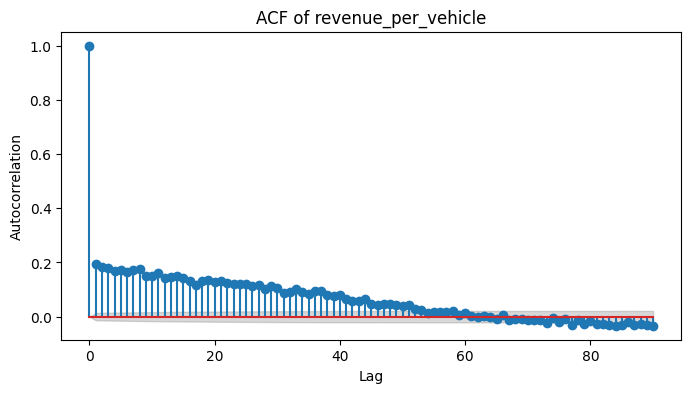

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Suppose you have a pandas Series of your raw (not log’d) target:
dates = pd.date_range(start="2023-01-01", periods=len(y_true), freq="D")
ser = pd.Series(y_true, index=dates)

# 1) Compute ACF up to, say, 30 lags
nlags = 90
acf_vals, confint = acf(ser, nlags=nlags, alpha=0.05)

# 2) Plot it
lags = np.arange(nlags+1)
plt.figure(figsize=(8,4))
plt.stem(lags, acf_vals)
plt.fill_between(lags,
                 confint[:,0] - acf_vals,
                 confint[:,1] - acf_vals,
                 color='gray', alpha=0.3)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("ACF of revenue_per_vehicle")
plt.show()


In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

weekly = pd.read_feather('data/output/df_features_seoul.feather')
weekly_df  = weekly.copy()

# 1) Prepare X, y from your weekly DataFrame (no log-transform if you want direct revenue; or predict log and exp‐back)
features = [
    'vehicle_count',
    'T', 'RH', 'P', 'W', 'S', 'offday_run', 't',
    'weather_score','coupon_count',
    'sin_doy', 'cos_doy',
    'rain_flag', 'windy_flag', 'rain_weekend', 'hot_weekday',
    'sin_month', 'cos_month', 'days_to_hol','is_holiday',
    'rev_lag1', 'rev_lag7', 'rev_ma7', 'rev_std7',
    # # 인구 통계 변수
    'femlNmprCnt','maleNmprCnt', 'pct_child', 'pct_teen', 'pct_adult', 'pct_senior',
    #'totNmprCnt','femlNmprCnt','maleNmprCnt',  
    # 조정 지가
    'adj_land_price'
]

# features = [
#     'vehicle_count','week_of_year',

#     'T', 'RH', 'P', 'W', 'S', 'weather_score',
#     'is_holiday', 'days_to_hol',
#     'rain_flag', 'windy_flag', 'coupon_count',
#     # # 인구 통계 변수
#     'total_female','total_male', 'pct_child', 'pct_teen', 'pct_adult', 'pct_senior',
#     #'totNmprCnt','femlNmprCnt','maleNmprCnt',
#     # 조정 지가
#     'adj_land_price',
#     # cyclical
#     'sin_woy','cos_woy','sin_month','cos_month'
# ]

X = weekly_df[features]
y = weekly_df['revenue_per_vehicle']

# 2) Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Create LightGBM datasets
dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

# 4) Set up parameters
params = {
    'objective':        'regression',
    'metric':           'rmse',
    'learning_rate':    0.05,
    'num_leaves':       64,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq':     5,
    'seed':             42,
    'verbosity':        -1,
}

bst = lgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dval],
    valid_names=['train','val'],
    callbacks=[
        #lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)
    ]
)

# 6) Predict & evaluate
y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
# compute mean squared error (default returns MSE)
mse  = mean_squared_error(y_val, y_pred)

# then take its square root for RMSE
rmse = np.sqrt(mse)

print(f"LightGBM RMSE: {rmse:.3f}")

[50]	train's rmse: 20049.4	val's rmse: 20673.6
[100]	train's rmse: 19146	val's rmse: 20182.6
[150]	train's rmse: 18586.9	val's rmse: 20025.1
[200]	train's rmse: 18205.6	val's rmse: 19954.7
[250]	train's rmse: 17882.2	val's rmse: 19905.9
[300]	train's rmse: 17596.1	val's rmse: 19881.2
[350]	train's rmse: 17318.4	val's rmse: 19857.6
[400]	train's rmse: 17063.6	val's rmse: 19850.2
[450]	train's rmse: 16824.1	val's rmse: 19847.9
[500]	train's rmse: 16583.2	val's rmse: 19854.3
[550]	train's rmse: 16356.2	val's rmse: 19857.8
[600]	train's rmse: 16134.3	val's rmse: 19860.9
[650]	train's rmse: 15918.1	val's rmse: 19858.1
[700]	train's rmse: 15726.8	val's rmse: 19857.7
[750]	train's rmse: 15540.3	val's rmse: 19864.6
[800]	train's rmse: 15348.4	val's rmse: 19872
[850]	train's rmse: 15160.4	val's rmse: 19874.4
[900]	train's rmse: 14979.8	val's rmse: 19879.6
[950]	train's rmse: 14807	val's rmse: 19881
[1000]	train's rmse: 14641.5	val's rmse: 19883.2
[1050]	train's rmse: 14471.8	val's rmse: 19891.4

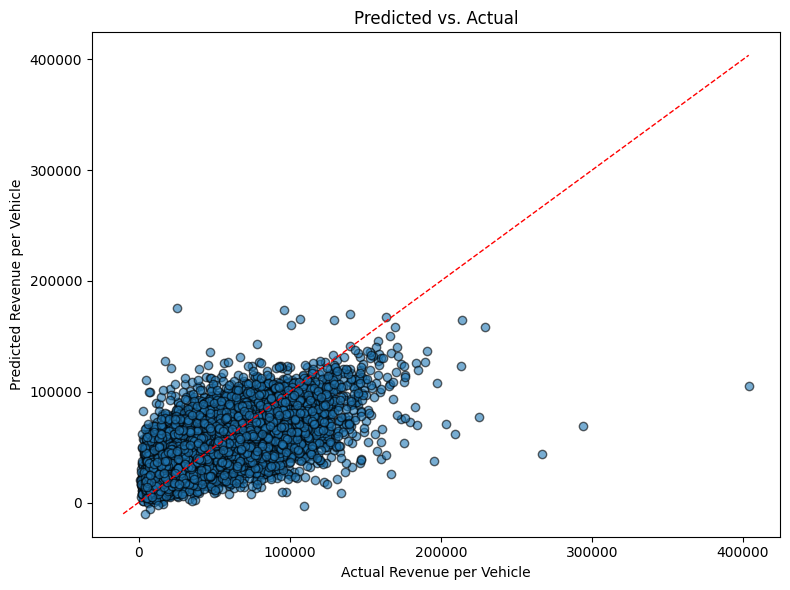

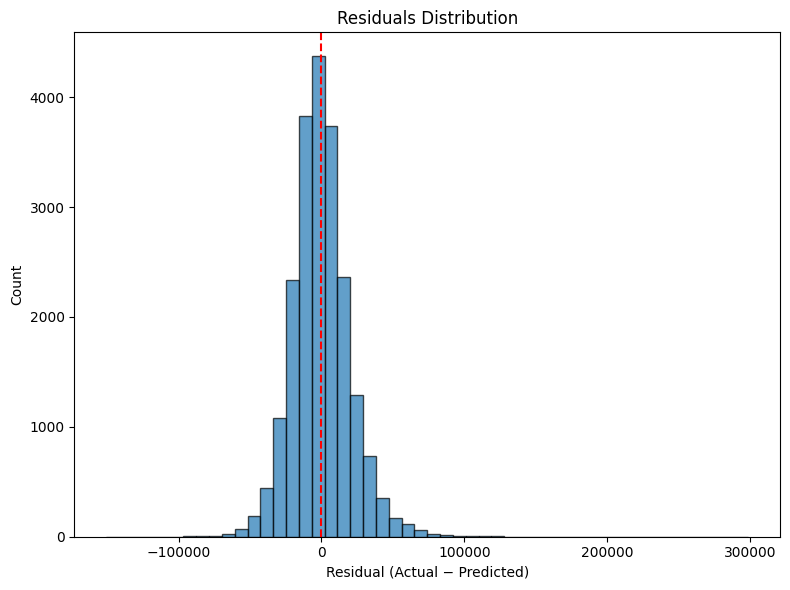

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# ----- Replace these two lines with however you obtain your arrays -----
# For example, from your model run:
#    y_val  = y_true_log_clipped   # or the de-logged values
#    y_pred = y_pred_log_clipped
# Make sure they’re both 1-D numpy arrays of the same length
# ------------------------------------------------------------------------
# y_val  = np.exp(y_val)  
# y_pred = np.exp(y_pred)

# Scatter: Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6, edgecolor='k')
mn = min(y_val.min(), y_pred.min())
mx = max(y_val.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1)
plt.xlabel('Actual Revenue per Vehicle')
plt.ylabel('Predicted Revenue per Vehicle')
plt.title('Predicted vs. Actual')
plt.tight_layout()
plt.show()

# Residuals histogram
residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='k')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residual (Actual − Predicted)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()


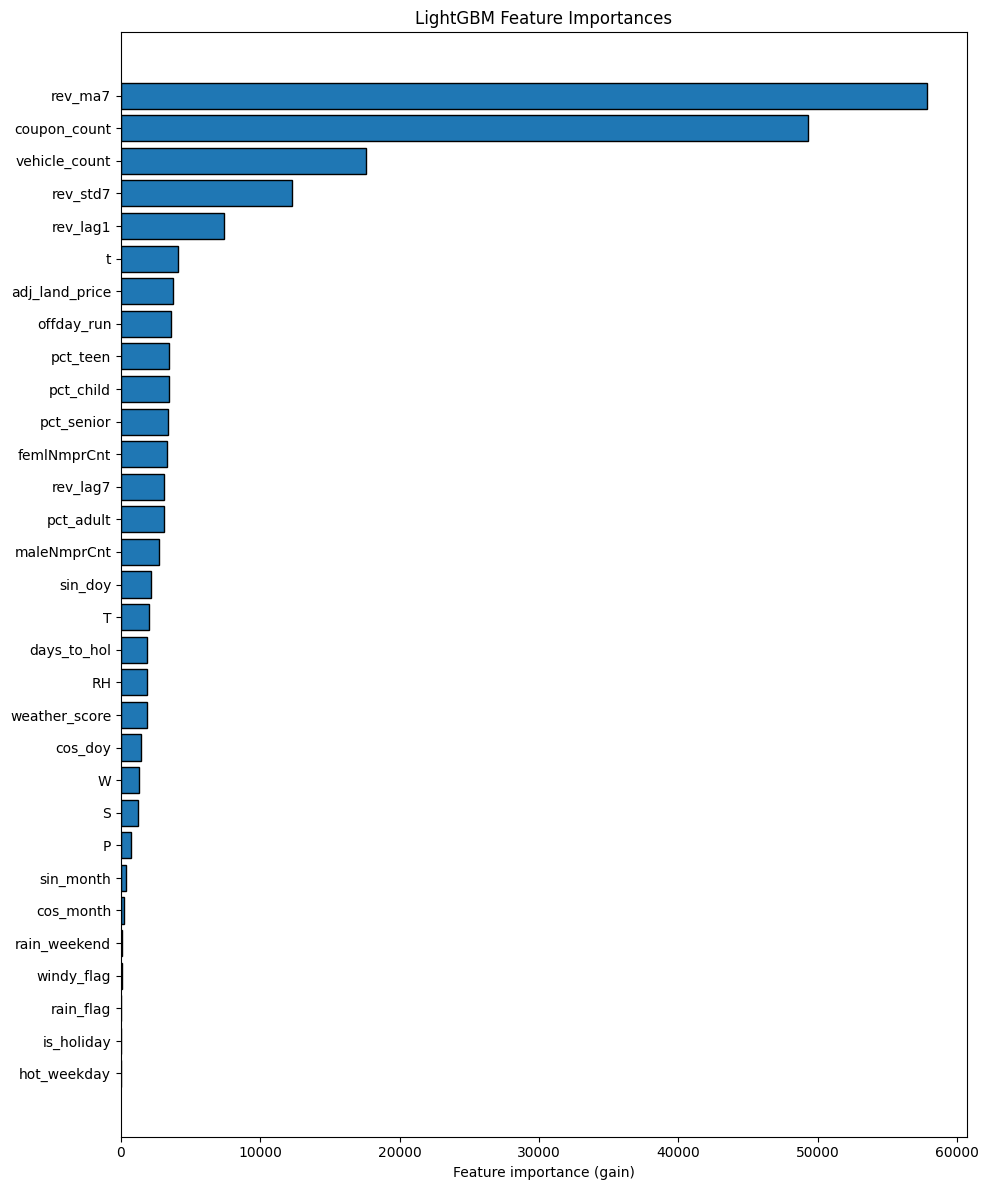

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 1) extract raw importances and feature names
#    use 'gain' to see which splits gave the most reduction in loss
importances   = bst.feature_importance(importance_type='gain')
feature_names = np.array(features)

# 2) sort descending
idx = np.argsort(importances)[::-1]
sorted_feats = feature_names[idx]
sorted_imp   = importances[idx]

# 3) plot
plt.figure(figsize=(10, 12))
plt.barh(sorted_feats, sorted_imp, edgecolor='k')
plt.gca().invert_yaxis()            # highest importance at the top
plt.xlabel('Feature importance (gain)')
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()
